# Kalman Filtering Investigation

This notebook investigates whether the use of a kalman filter for speed estimation works or not.

This will be done by first defining a test "true" speed and cadence profile. From this "true" profile, quantized data that simulates the bluetooth sensors (one "tick" per revolution) will be created. The Kalman filter will then be tested against this simulated quantized data to compare the Kalman filter's estimate with the "true" data.

In [81]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import integrate

matplotlib.rcParams['figure.figsize'] = (18, 16)

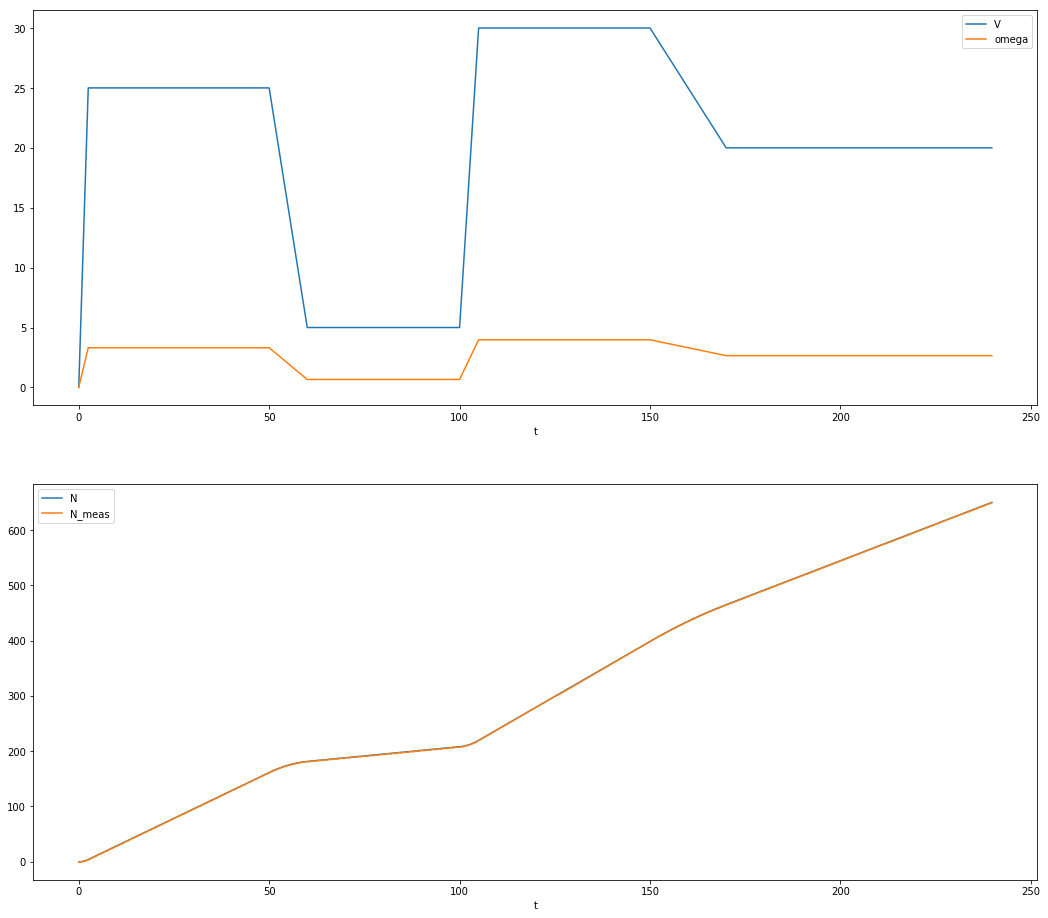

In [82]:
ROLLING_LENGTH = 2096.
DT = 0.25

sim_data = pd.DataFrame({
    "t": pd.Series(np.arange(0., 240., step=DT, dtype=np.float)),
}).assign(
    V=[t * 10 if t < 2.5 else
       25 if t < 50 else
       (50 - t) * 2 + 25 if t < 60 else
       5 if t < 100 else
       (t - 100) * 5 + 5 if t < 105 else
       30 if t < 150 else
       (150 - t) * 0.5 + 30 if t < 170 else
       20
       for t in sim_data.t]
).assign(
    omega=[V * 1e+6 / ROLLING_LENGTH / 3600. for V in sim_data.V]
).assign(
    N=np.insert(integrate.cumtrapz(sim_data.omega, sim_data.t), 0, 0)
).assign(
    N_meas=[np.floor(N) for N in sim_data.N]
)

fig, ax = plt.subplots(nrows=2, facecolor="white")
sim_data.plot(ax=ax[0], x='t', y="V")
sim_data.plot(ax=ax[0], x='t', y="omega")
sim_data.plot(ax=ax[1], x='t', y="N")
sim_data.plot(ax=ax[1], x="t", y="N_meas")

In general, an extended Kalman filter requires a model with a state update function of the form:

$$
x_{k+1} = f\left(x_k, u_k, k\right) + w_k
$$

The system modelled has an output of the form:

$$
y_k = h\left(x_k, u_k, k\right) + v_k
$$

$x_k$ is the state variable, $y_k$ is the output variable, $u_k$ is the input variable, and $w_k$ and $v_k$ are zero-mean white Gaussian additive noises.

In our case, out state variable has two components: the rotation count, and the speed. Thus, the state update function is:

$$
k_{k+1} = \begin{bmatrix}N_{k+1} \\ \omega_{k+1}\end{bmatrix} = \begin{bmatrix}N_k + \Delta T \omega_k \\ \omega_k\end{bmatrix}
$$



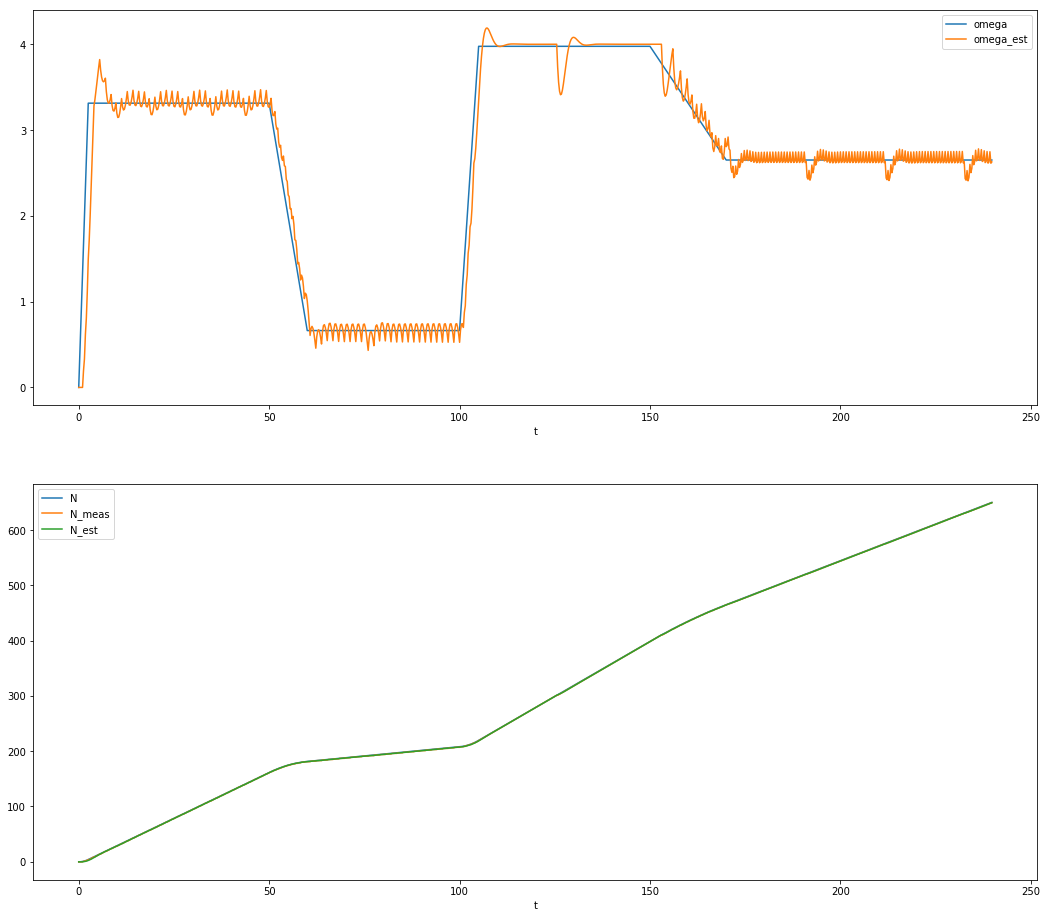

In [115]:
def kalman1(z_data, dt):
    A = np.array([[1, dt], [0, 1]])
    H = np.array([[1, 0]])
    Q = np.array([[0.0001, 0.1], [0.0001, 100]]) / 100000
    R = 1 / 12 * 10  # This should be simply 1/12
    
    # Initialize the variables
    x_hat = np.array([[z_data[0], 0]]).T
    P = np.eye(2, 2)
    
    x_store = np.zeros((len(z_data), 2))
    
    for i, z in enumerate(z_data):
        x_hatminus = np.dot(A, x_hat)  # 2x1
        P_minus = np.dot(np.dot(A, P), A.T) + Q  # 2x2
        K = np.dot(P_minus, H.T) / (np.dot(np.dot(H, P_minus), H.T) + R)  # 2x1
        x_hat = x_hatminus + K * (z - np.dot(H, x_hatminus))
        P = (np.eye(2, 2) - K * H) * P_minus
        x_store[i, :] = x_hat.T
    
    return x_store


res = kalman1(sim_data.N_meas, DT)
kalman1_result = sim_data.assign(N_est=pd.Series(res[:, 0])).assign(omega_est=pd.Series(res[:, 1]))

fig, ax = plt.subplots(nrows=2, facecolor="white")
kalman1_result.plot(ax=ax[0], x='t', y="omega")
kalman1_result.plot(ax=ax[0], x='t', y="omega_est")
kalman1_result.plot(ax=ax[1], x='t', y="N")
kalman1_result.plot(ax=ax[1], x="t", y="N_meas")
kalman1_result.plot(ax=ax[1], x="t", y="N_est")

In [5]:

len(sim_data)

960